In [1]:
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"]="7"
CORE_DIR = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), "core")
CORE_DIR_2 = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), "core/")
sys.path.append(os.path.dirname(CORE_DIR))
sys.path.append(os.path.dirname(CORE_DIR_2))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast

import numpy as np
import argparse
from time import time
from loguru import logger
import matplotlib.pyplot as plt
import tifffile

from model import get_model
from utils.utils import load_json
from utils.data_utils import get_data, normalize_imgs, denormalize_imgs
from utils.torch_utils import setup_DDP, load_ckpt

from utils.nn_utils import flow_warp, flow_warp_old

ImportError: cannot import name 'flow_warp_old' from 'utils.nn_utils' (/nfs/scratch2/inacio/code/denoising/cryosamba/core/utils/nn_utils.py)

In [ ]:
seed = 1234
world_size, rank, device = setup_DDP(seed)
is_ddp = (world_size > 1)

In [ ]:
# @torch.inference_mode
# def run_model(imgs, cfg, model, is_ddp, metadata, TTA):
#     with autocast(enabled=cfg.train.mixed_precision):
#         rec = model.forward(imgs, metadata, TTA=TTA, mode='inference')

#     return rec.squeeze().cpu().detach().numpy()

def auto_contrast(image, sigma=2):
    mean = np.mean(image)
    std = np.std(image)
    
    lower_value = mean - sigma * std
    upper_value = mean + sigma * std

    image = (image - lower_value) / (upper_value - lower_value)

    return image

def fft(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.fftshift(x)))

# Fourier

In [ ]:

config = '../configs/nova/rotacell_grid1_TS09_ctf_3xBin_train.json'
# config = '../configs/benchmark/linux_train.json'
cfg = load_json(config)

max_frame_gap = 30
coords = [400,850,800]
patch_shape = [128,256,256]
TTA = False
batch_size = 32

In [ ]:
cfg = load_json(os.path.join(cfg.train_dir, "config.json"))

data, metadata = get_data(cfg.data_path[0])

crop = []
for i in range(patch_shape[0]):
    z = coords[0]+i
    roi = np.asarray(data[z-max_frame_gap:z+max_frame_gap+1, coords[1]-patch_shape[1]:coords[1], coords[2]:coords[2]+patch_shape[2]])
    crop.append(roi)
crop = torch.from_numpy(np.asarray(crop))

load_ckpt_path = os.path.join(cfg.train_dir, 'last.pt')
model = get_model(cfg, device, is_ddp, compile=False)
model = load_ckpt(load_ckpt_path, model, is_ddp=is_ddp, compile=False)[0]
model.eval();

In [ ]:
crop.shape

In [ ]:
z = 64
gap = 10

middle = crop.shape[1]//2
img0, imgT, img1 = crop[z,middle-gap], crop[z,middle], crop[z,middle+gap]
img0 = img0.unsqueeze(0).unsqueeze(0).to(device)
imgT = imgT.unsqueeze(0).unsqueeze(0).to(device)
img1 = img1.unsqueeze(0).unsqueeze(0).to(device)
img0 = normalize_imgs(img0, params=metadata)
img1 = normalize_imgs(img1, params=metadata)

with torch.inference_mode():
    biflow = model.biflownet(img0, img1)
    rec = model.fusionnet(img0, img1, biflow) 

img0 = denormalize_imgs(img0, params=metadata)
img1 = denormalize_imgs(img1, params=metadata)
    
biflow = biflow.squeeze().cpu().detach().numpy()
img0 = img0.squeeze().cpu().detach().numpy()
imgT = imgT.squeeze().cpu().detach().numpy()
img1 = img1.squeeze().cpu().detach().numpy()
rec = rec.squeeze().cpu().detach().numpy()
mag0 = np.sqrt(biflow[0]**2+biflow[1]**2)
mag1 = np.sqrt(biflow[2]**2+biflow[3]**2)


In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.imshow(img0)
plt.subplot(2,3,2)
plt.imshow(imgT)
plt.subplot(2,3,3)
plt.imshow(img1)
plt.subplot(2,3,4)
plt.imshow(mag0)
plt.subplot(2,3,5)
plt.imshow(rec)
plt.subplot(2,3,6)
plt.imshow(mag1)
plt.show()

In [41]:
N,H,W = 2,64,64
img = torch.zeros(N,1,H,W, device=device)
img[:,:,16:32,16:32]=1
flow = torch.zeros(N,2,H,W, device=device)
flow[0,:,16:32,16:32]=5
flow[1,:,16:32,16:32]=10

a = flow_warp_shit(img, flow)
b = flow_warp_old(img, flow)

In [19]:
%timeit flow_warp_shit(img, flow)

477 µs ± 40.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [20]:
%timeit flow_warp_old(img, flow)

252 µs ± 347 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


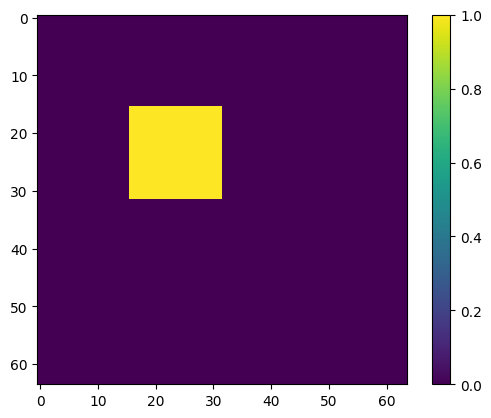

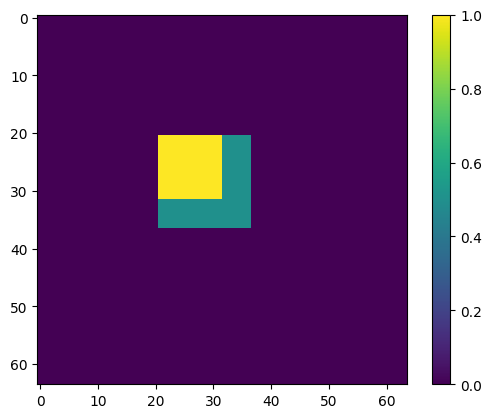

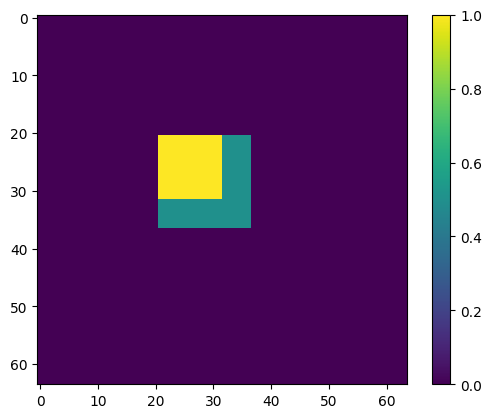

In [43]:
i = 0

plt.imshow(img[i].squeeze().cpu().detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(a[i].squeeze().cpu().detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(b[i].squeeze().cpu().detach().numpy())
plt.colorbar()
plt.show()

In [16]:
import torch
import torch.nn.functional as F

def FunctionSoftsplat(tenInput, tenFlow, tenMetric, strType):
    B, C, H, W = tenInput.shape

    # Initialize an empty output tensor and count tensor for normalization
    tenOutput = torch.zeros(B, C, H, W, device=tenInput.device)
    count = torch.zeros(B, 1, H, W, device=tenInput.device)

    # Generate a grid of coordinates
    xx = torch.arange(0, W, device=tenInput.device).view(1, 1, 1, W).expand(B, 1, H, W)
    yy = torch.arange(0, H, device=tenInput.device).view(1, 1, H, 1).expand(B, 1, H, W)
    base_grid = torch.cat((xx, yy), 1).float()

    # Calculate new coordinates based on the flow
    new_coords = base_grid + tenFlow
    new_coords = new_coords.round().long()

    # Clip the coordinates to image boundaries
    new_coords[:, 0, :, :] = torch.clamp(new_coords[:, 0, :, :], 0, W - 1)
    new_coords[:, 1, :, :] = torch.clamp(new_coords[:, 1, :, :], 0, H - 1)

    # Flatten indices for efficient indexing
    flattened_new_x = new_coords[:, 0, :, :].reshape(-1)
    flattened_new_y = new_coords[:, 1, :, :].reshape(-1)
    batch_indices = torch.arange(B, device=tenInput.device).view(B, 1, 1).expand(B, H, W).flatten()

    # Calculate linear indices to scatter into the output
    linear_indices = batch_indices * H * W + flattened_new_y * W + flattened_new_x

    # Flatten the input to match the flattened indices
    flattened_input = tenInput.permute(0, 2, 3, 1).view(-1, C)

    # Scatter-add the input pixels into the output
    for c in range(C):
        tenOutput.view(-1, C)[:, c].scatter_add_(0, linear_indices, flattened_input[:, c])

    # Scatter-add to count the number of pixels per destination location
    count.view(-1).scatter_add_(0, linear_indices, torch.ones_like(linear_indices, dtype=torch.float32))

    # Avoid division by zero by setting zero counts to 1
    count[count == 0] = 1

    # Normalize based on the count
    tenOutput /= count

    return tenOutput

In [17]:
def flow_warp_shit(img, flow):
    return FunctionSoftsplat(tenInput=img, tenFlow=flow, tenMetric=None, strType='average')